# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
import time
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 1. Data

In [2]:
cn7 = pd.read_csv("../data/processed/labeled_data_cn7.csv", parse_dates=True)

In [3]:
cn7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3974 entries, 0 to 3973
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TimeStamp                 3974 non-null   object 
 1   Hopper_Temperature        3974 non-null   float64
 2   Mold_Temperature_4        3974 non-null   float64
 3   Average_Back_Pressure     3974 non-null   float64
 4   Max_Screw_RPM             3974 non-null   float64
 5   Barrel_Temperature_1      3974 non-null   float64
 6   Reason                    3974 non-null   object 
 7   Max_Injection_Pressure    3974 non-null   float64
 8   Max_Injection_Speed       3974 non-null   float64
 9   Barrel_Temperature_2      3974 non-null   float64
 10  Barrel_Temperature_5      3974 non-null   float64
 11  Mold_Temperature_3        3974 non-null   float64
 12  Average_Screw_RPM         3974 non-null   float64
 13  Max_Switch_Over_Pressure  3974 non-null   float64
 14  Cushion_

# 2. Data Preprocessing

In [4]:
# Preparation of features for model training
numerical_features = [x for x in cn7.columns if np.dtype(cn7[x]) == "float64"]

In [5]:
# Data for passed parts
cn7_Y = cn7[cn7["PassOrFail"] == 0]
cn7_Y = cn7_Y[numerical_features]
print("No. of passed CN7 parts:", len(cn7_Y))

No. of passed CN7 parts: 3946


In [6]:
# Data for failed parts
cn7_N = cn7[cn7["PassOrFail"] == 1]
cn7_N = cn7_N[numerical_features]
print("No. of failed CN7 parts:", len(cn7_N))

No. of failed CN7 parts: 28


In [7]:
# The model using Mahalanobis Distance is trained by Data for passed parts (i.e., data with a majority class)
cn7_train_Y, cn7_test_Y = train_test_split(cn7_Y, test_size=0.1)

# Test set with failed parts
cn7_test_N = cn7_N

print(f"No. of Train Set (Passed Parts): {len(cn7_train_Y)}")
print(f"No. of Test Set (Passed Parts): {len(cn7_test_Y)}")
print(f"No. of Test Set (Failed Parts): {len(cn7_test_N)}")

No. of Train Set (Passed Parts): 3551
No. of Test Set (Passed Parts): 395
No. of Test Set (Failed Parts): 28


In [8]:
# Data normalization

scaler = StandardScaler()

cn7_train_Y = scaler.fit_transform(cn7_train_Y)
cn7_test_Y = scaler.transform(cn7_test_Y)
cn7_test_N = scaler.transform(cn7_test_N)

# 3. Mahalanobis Distance

In [9]:
def mahalanobis(x=None, data=None, cov=None):
    """
    Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data, axis=0)
    if not cov:
        cov = np.cov(data.T)
        # cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()  # Can't understand why .diagonal() is used

In [10]:
class MahalanobisOneclassClassifier():
    def __init__(self, xtrain, significance_level=0.01):
        self.xtrain = xtrain
        self.critical_value = chi2.ppf((1-significance_level), df=xtrain.shape[1] - 1) # df = degree of freedom
        print('Critical value is: ', self.critical_value)

    def predict_proba(self, xtest):
        mahalanobis_dist = mahalanobis(xtest, self.xtrain)
        self.pvalues = 1 - chi2.cdf(mahalanobis_dist, 2)
        return mahalanobis_dist

    def predict(self, xtest):
        return np.array([int(i) for i in self.predict_proba(xtest) > self.critical_value])

# 4. Setup of Threshold

In [11]:
clf = MahalanobisOneclassClassifier(cn7_train_Y, significance_level=0.1)

Critical value is:  30.813282343953027


In [12]:
threshold = clf.critical_value

# 5. Classification of Test Set by Mahalanobis Distance

## 5.1. Evaluation Using Test Set (Passed Parts)

In [13]:
# Prediction of Mahalanobis Distance
cn7_MD_Y = clf.predict_proba(cn7_test_Y)

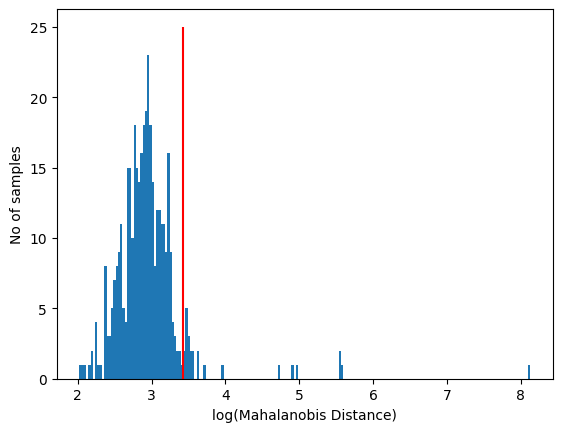

In [14]:
# Data Visualization 
# Log was used for better visualization

plt.hist(np.log(cn7_MD_Y), bins=200)
plt.xlabel("log(Mahalanobis Distance)")
plt.ylabel("No of samples")
plt.vlines(np.log(threshold), 0, 25, color="red")
plt.show();

In [15]:
# Check on the data that were predicted as failed parts

cn7_test_Y_anomalies = cn7_MD_Y > threshold
print("No. of Failed Parts:", np.sum(cn7_test_Y_anomalies))
print("Accuracy:", (cn7_test_Y.shape[0]-np.sum(cn7_test_Y_anomalies))/cn7_test_Y.shape[0])

No. of Failed Parts: 25
Accuracy: 0.9367088607594937


## 5.2. Evaluation Using Test Set (Failed Parts)

In [16]:
# Prediction of Mahalanobis Distance
cn7_MD_N = clf.predict_proba(cn7_test_N)

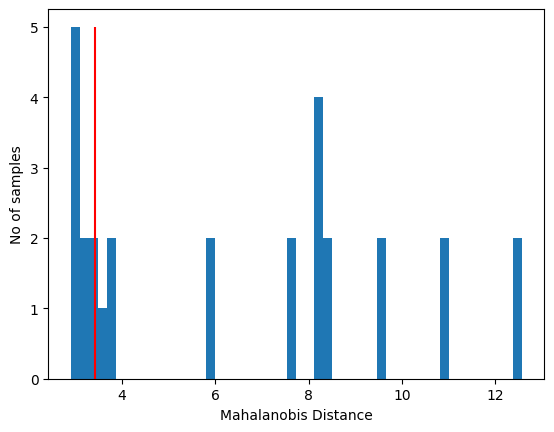

In [17]:
# Data visualization 
# Log was used for better visualization

plt.hist(np.log(cn7_MD_N), bins=50)
plt.xlabel("Mahalanobis Distance")
plt.ylabel("No of samples")
plt.vlines(np.log(threshold), 0, 5, color="red")
plt.show();

In [18]:
# Check on the data that were predicted as failed parts

cn7_test_N_anomalies = cn7_MD_N > threshold
print("No. of Failed Parts:", np.sum(cn7_test_N_anomalies))
print("Accuracy:", np.sum(cn7_test_N_anomalies)/cn7_test_N.shape[0])

No. of Failed Parts: 20
Accuracy: 0.7142857142857143


# 6. Result Analysis

In [19]:
# True values for the test set

cn7_true = np.concatenate(
    [np.zeros(len(cn7_test_Y_anomalies)), np.ones(len(cn7_test_N_anomalies))]
)

In [20]:
# Predicted values for the test set

cn7_prediction = np.concatenate(
    [cn7_test_Y_anomalies, cn7_test_N_anomalies]
)

In [21]:
confusion_matrix(cn7_true, cn7_prediction)

array([[370,  25],
       [  8,  20]], dtype=int64)

In [22]:
print(classification_report(cn7_true, cn7_prediction))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       395
         1.0       0.44      0.71      0.55        28

    accuracy                           0.92       423
   macro avg       0.71      0.83      0.75       423
weighted avg       0.94      0.92      0.93       423



- Performance of the model using Mahalanobis Distance was slightly less effective than the machine learning models.